In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import gseapy
import seaborn as sns
import statsmodels.api as sm
# use anaconda/miniconda to ensure packages are right version, otherwise plotting might give error for color

## Load data

In [2]:
adata = sc.read_csv("data/GSM3399102_rawCounts.csv.gz").T

The raw UMI counts from Cell Ranger was processed by the Seurat R package (version 1.4) (Butler et al., 2018; Macosko et al., 2015). Genes that were detected in less than three cells were removed. Cells in which over 5% of the UMIs were mapped to the mitochondrial genes were discarded, and cells that contained less than 200 or over 4800 genes were considered outliers and discarded. Library-size normalization was performed on the UMI-collapsed gene expression for each barcode by scaling the total number of transcripts per cell to 10,000. The data were then log2 transformed. In total, 9,306 cells and 15,823 genes (an average of 1200 detected genes/cell) were used in the cell type determination.

Linear regression was used to regress out the total number of UMIs and the fraction of mitochondrial transcript content per cell. The variable genes were identified using Seurat’s MeanVarPlot function using the following parameters: x.low.cutoff = 0.0; y.cutoff = 0.8, resulting in 1945 variable genes. These variable genes were used in the principal component analysis. The first 23 principal components were used for cell clustering with a resolution at 0.6, and low dimensional reduction to visualize cell clusters. Specific genes for each cluster were identified using the Seurat’s FindAllMarkers function. To refine clustering, the SubsetData function was used to create a new Seurat object containing only a subset of the original cells and cell clustering was reiterated.



In [3]:
# filter genes expressed in less than 3 ells
sc.pp.filter_genes(adata, min_cells=3)

## 1. Quality control

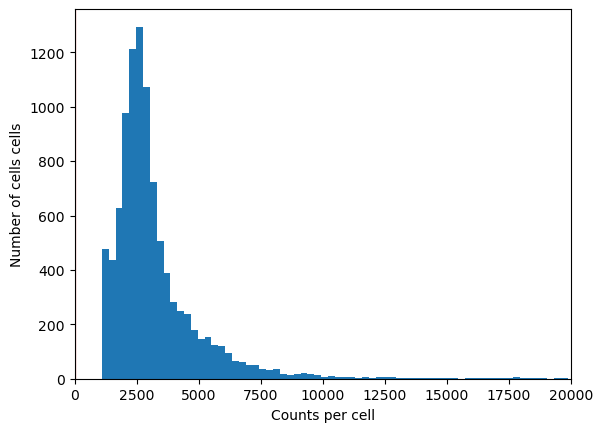

In [4]:
adata.obs['n_counts'] = adata.X.sum(axis=1)
plt.hist(adata.obs['n_counts'], bins=100)
plt.xlabel("Counts per cell") # what are you plotting on the x-axis? Label it!
plt.ylabel("Number of cells cells") # what are you plotting on the x-axis? Label it!
plt.axvline(0, c="r") # specify the lower cutoff value for total UMIs
plt.axvline(0, c="r") # specify the upper cutoff value for total UMIs
plt.xlim(0, 20000)
plt.show()

From the plot, the data is already filtered for UMI counts per cell

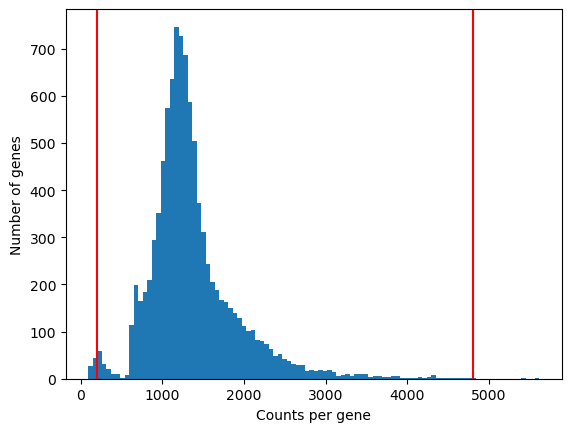

In [5]:
# look at gene counts per gene
expressed_genes = np.sum(adata.X > 0, 1)
adata.obs['n_genes'] = expressed_genes

plt.hist(adata.obs['n_genes'], bins=100)
plt.axvline(200, c="r") # specify the lower cutoff for number of detected genes
plt.axvline(4800, c="r") # specify the upper cutoff for number of detected genes
plt.xlabel("Counts per gene") # what are you plotting on the x-axis? Label it!
plt.ylabel("Number of genes") # what are you plotting on the x-axis? Label it!
plt.show()

c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

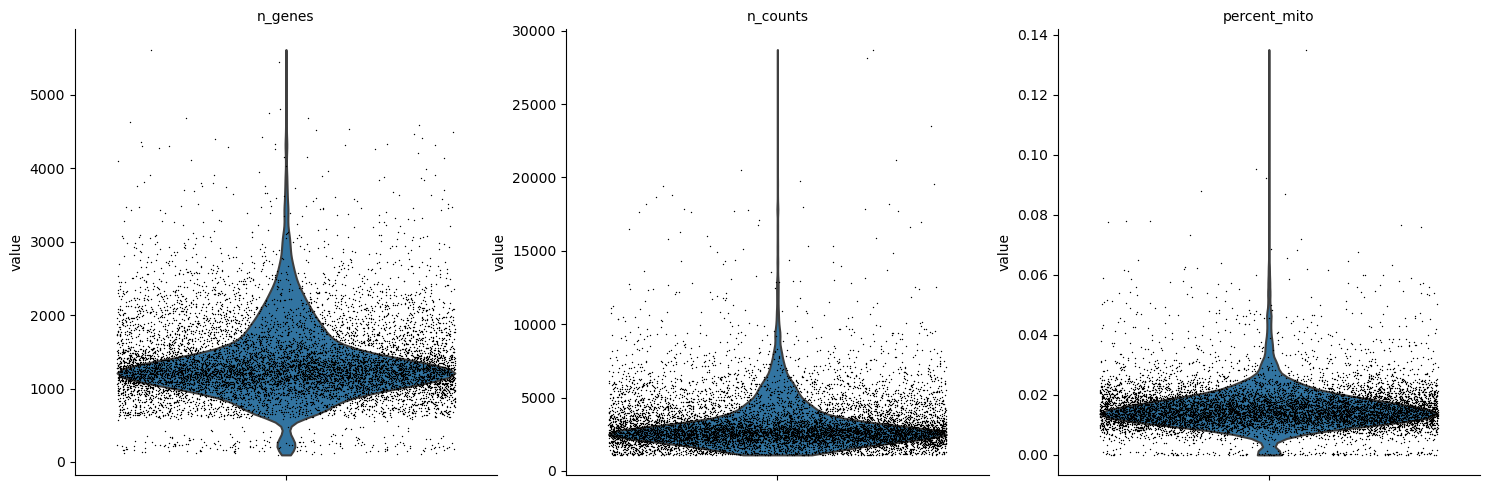

In [6]:
# finally check percentage of mitochondrial genes
mito_genes = adata.var_names.str.startswith('mt-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)

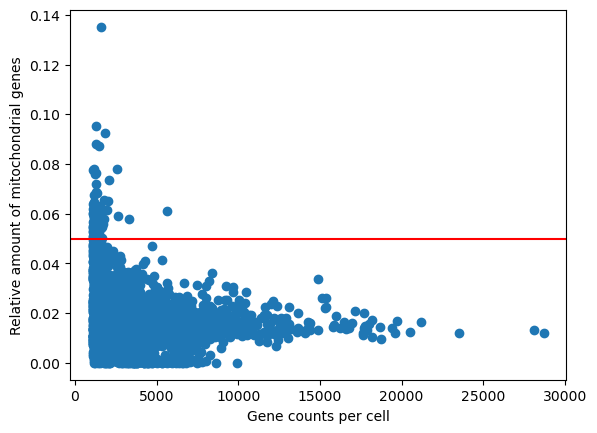

In [7]:
plt.scatter(adata.obs["n_counts"], adata.obs["percent_mito"])
plt.xlabel("Gene counts per cell") # specify the lower cutoff for number of detected genes
plt.ylabel("Relative amount of mitochondrial genes") # specify the lower cutoff for number of detected genes
plt.axhline(0.05, c='red') # specify a threshold (decimal from 0 to 1) for percentage mitochondrial reads
plt.show()

## 1.1 filter the data
Based on the above plots, we suggest to cut-off data for higher than 0.04 mitochondrial percentage,and to keep data within 500 and 3500 counts per gene and 1000to 10,000 gene counts per cell.
To improve, set boundaries with some algorithm based on the distributions?

In [8]:
sc.pp.filter_cells(adata, min_genes=200) # apply threshold from above to actually do the filtering
sc.pp.filter_cells(adata, max_genes=4800) # apply threshold from above to actually do the filtering
adata = adata[adata.obs['percent_mito'] < 0.05, :].copy() # apply threshold from above to actually do the filtering

In [9]:
adata

AnnData object with n_obs × n_vars = 9708 × 15828
    obs: 'n_counts', 'n_genes', 'percent_mito'
    var: 'n_cells'

## 2. Normalization
Address variability caused by sc sequencing process

In [10]:
adata.raw = adata.copy()
adata_raw = adata.copy()

In [11]:
sc.pp.normalize_total(adata, target_sum=10000)
sc.pp.log1p(adata)

## 3. Feature selection

In [12]:
# Get cell states (S, G2m vs G1, G0)
S_genes_mouse = ['Mcm5', 'Pcna', 'Tyms', 'Fen1', 'Mcm2', 'Mcm4', 'Rrm1', 'Ung',
       'Gins2', 'Mcm6', 'Cdca7', 'Dtl', 'Prim1', 'Uhrf1', 'Cenpu',
       'Hells', 'Rfc2', 'Rpa2', 'Nasp', 'Rad51ap1', 'Gmnn', 'Wdr76',
       'Slbp', 'Ccne2', 'Ubr7', 'Pold3', 'Msh2', 'Atad2', 'Rad51', 'Rrm2',
       'Cdc45', 'Cdc6', 'Exo1', 'Tipin', 'Dscc1', 'Blm', 'Casp8ap2',
       'Usp1', 'Clspn', 'Pola1', 'Chaf1b', 'Brip1', 'E2f8']
G2M_genes_mouse = ['Hmgb2', 'Cdk1', 'Nusap1', 'Ube2c', 'Birc5', 'Tpx2', 'Top2a',
       'Ndc80', 'Cks2', 'Nuf2', 'Cks1b', 'Mki67', 'Tmpo', 'Cenpf',
       'Tacc3', 'Pimreg', 'Smc4', 'Ccnb2', 'Ckap2l', 'Ckap2', 'Aurkb',
       'Bub1', 'Kif11', 'Anp32e', 'Tubb4b', 'Gtse1', 'Kif20b', 'Hjurp',
       'Cdca3', 'Jpt1', 'Cdc20', 'Ttk', 'Cdc25c', 'Kif2c', 'Rangap1',
       'Ncapd2', 'Dlgap5', 'Cdca2', 'Cdca8', 'Ect2', 'Kif23', 'Hmmr',
       'Aurka', 'Psrc1', 'Anln', 'Lbr', 'Ckap5', 'Cenpe', 'Ctcf', 'Nek2',
       'G2e3', 'Gas2l3', 'Cbx5', 'Cenpa']

sc.tl.score_genes_cell_cycle(adata, s_genes=S_genes_mouse, g2m_genes=G2M_genes_mouse)

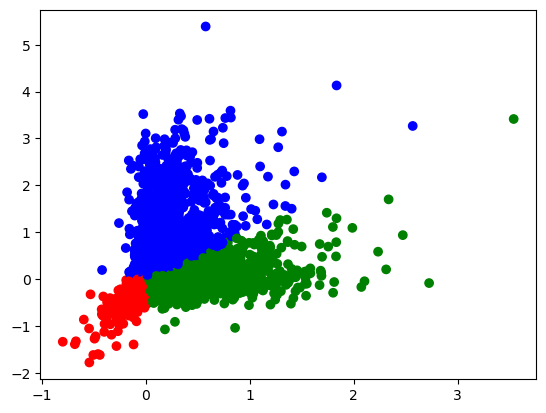

In [13]:
n2c = {"G1":"red", "S":"green", "G2M":"blue"} # use to assign each cell a color based on phase in the scatter plot
colors = []
for phase in adata.obs['phase']:
    colors.append(n2c[phase])

plt.scatter(adata.obs['S_score'], adata.obs['G2M_score'], c=colors)
plt.show()

In [14]:
adata.obs["phase"].value_counts()

phase
G1     6798
S      1849
G2M    1061
Name: count, dtype: int64

Also regress out the effect of cell phase. Authors did not do this, but seems like a good idea if we want to look at pseudo time. So cell phase does not confound those results, or at least less.

In [15]:
# Linear regression was used to regress out the total number of UMIs and the fraction of mitochondrial transcript content per cell. 
sc.pp.regress_out(adata, ['n_counts', 'percent_mito', 'S_score', 'G2M_score']) # specify which feature from adata.obs you want to regress out, if any

Select 1945 highest variance components, as the authors wrote:
The variable genes were identified using Seurat’s MeanVarPlot function using the following parameters: x.low.cutoff = 0.0; y.cutoff = 0.8, resulting in 1945 variable genes. 

In [16]:
sc.pp.highly_variable_genes(adata, n_top_genes=1945, min_disp=0.5, 
                            max_disp=np.inf, min_mean=0.0125, max_mean=3, span=0.3)

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [17]:
adata = adata[:, adata.var["highly_variable"]].copy() # actually do the filtering

In [18]:
adata

AnnData object with n_obs × n_vars = 9708 × 1945
    obs: 'n_counts', 'n_genes', 'percent_mito', 'S_score', 'G2M_score', 'phase'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

## 4. Principal component analysis

In [19]:
sc.tl.pca(adata, svd_solver='arpack')

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


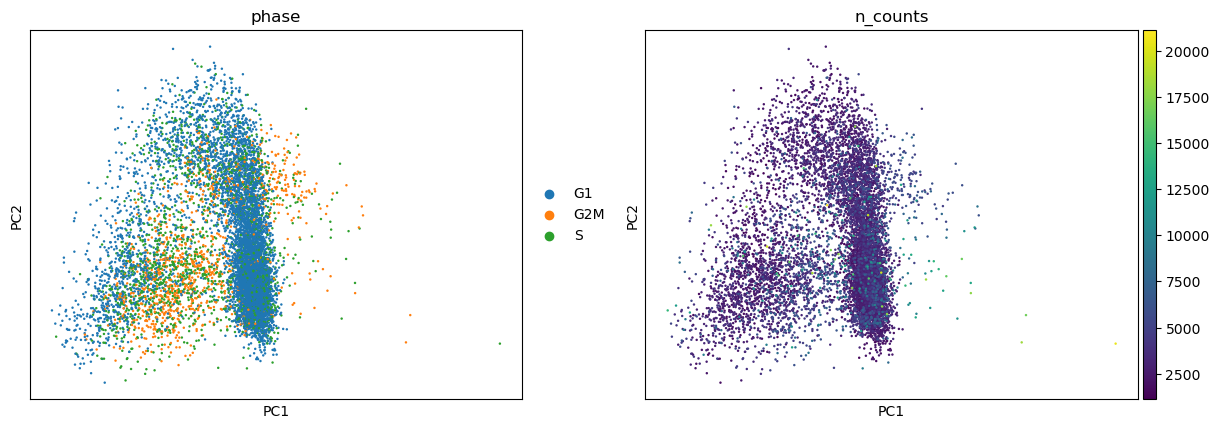

In [20]:
sc.pl.pca(adata, color=['phase','n_counts'])

In [21]:
# above shows a mix for the phase, which is good since it should be regressed out

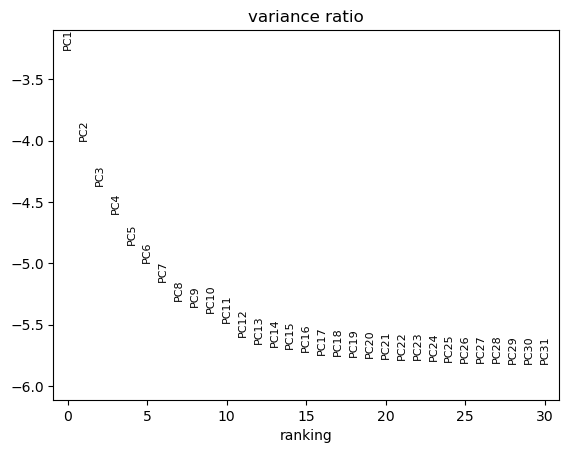

In [22]:
sc.pl.pca_variance_ratio(adata, log=True) # see contribution of each PC to variance

## 5. Dimensionality reduction 

In [23]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=20) # specify the number of neighbors and number of PCs you wish to use

c:\Users\jurri\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
sc.tl.tsne(adata, random_state=0)

c:\Users\jurri\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\jurri\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [25]:
sc.tl.umap(adata, alpha=0.3, min_dist=0.5, random_state=0)

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


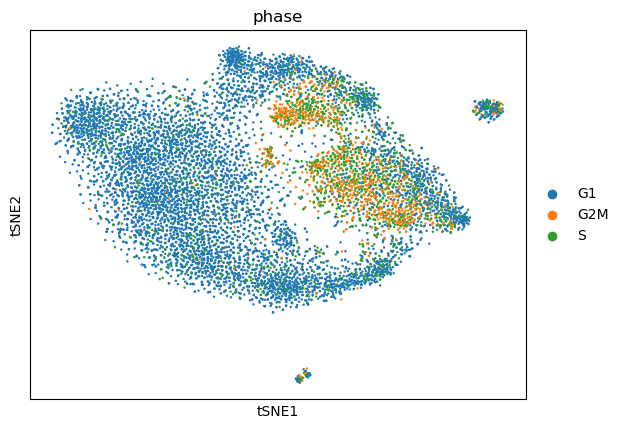

In [26]:
# visualize the tSNE colored by phase
sc.pl.tsne(adata, color='phase', use_raw=False, wspace=0.3, ncols=3)

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


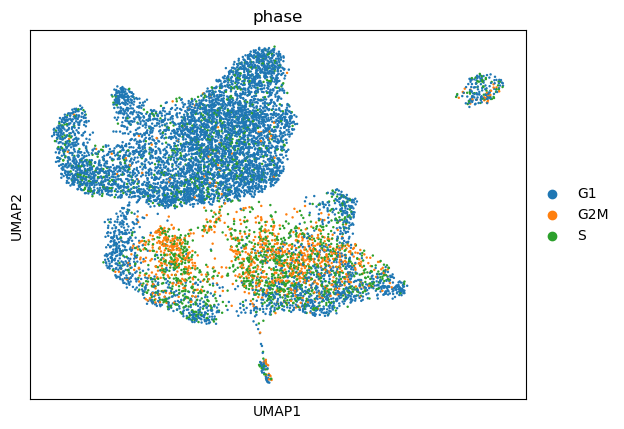

In [27]:
# visualize the UMAP colored by phase
sc.pl.umap(adata, color='phase', use_raw=False, wspace=0.3, ncols=3)

## 6. Clustering

In [28]:
resolution = 1.3
sc.tl.leiden(adata, resolution=resolution)

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


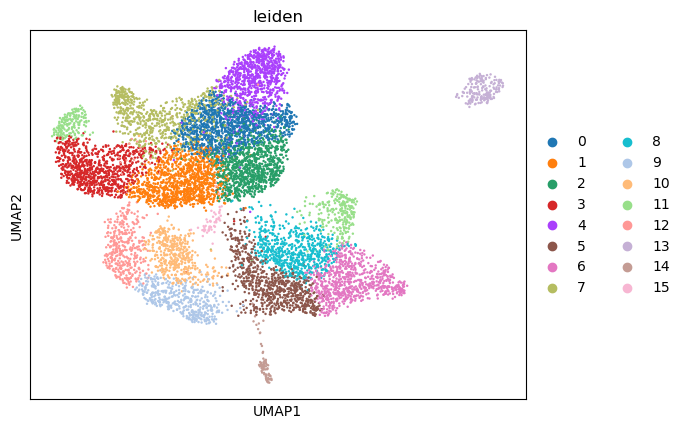

In [29]:
sc.pl.umap(adata, color=['leiden'], use_raw=False, wspace=0.3, ncols=2)

## 7. Identifying marker genes and cell types
Before proceeding with marker gene analysis and cell type annotation, restore the raw version of the data, add the necessary annotations, and normalize the counts:

In [30]:
adata_raw_norm = adata_raw.copy()

# normalize the counts
sc.pp.normalize_total(adata_raw_norm)
# log transform the counts
sc.pp.log1p(adata_raw_norm)
# transfer over the metadata
adata_raw_norm.obsm["X_umap"] = adata.obsm["X_umap"]
adata_raw_norm.obs["leiden"] = [i for i in adata.obs["leiden"]]

In [31]:
sc.tl.rank_genes_groups(adata_raw_norm, 'leiden', use_raw=False, method="t-test")

In [32]:
sc.tl.rank_genes_groups(adata, 'leiden', use_raw=False, method='wilcoxon', key_added = "wilcoxon")


c:\Users\jurri\miniconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning:

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obse

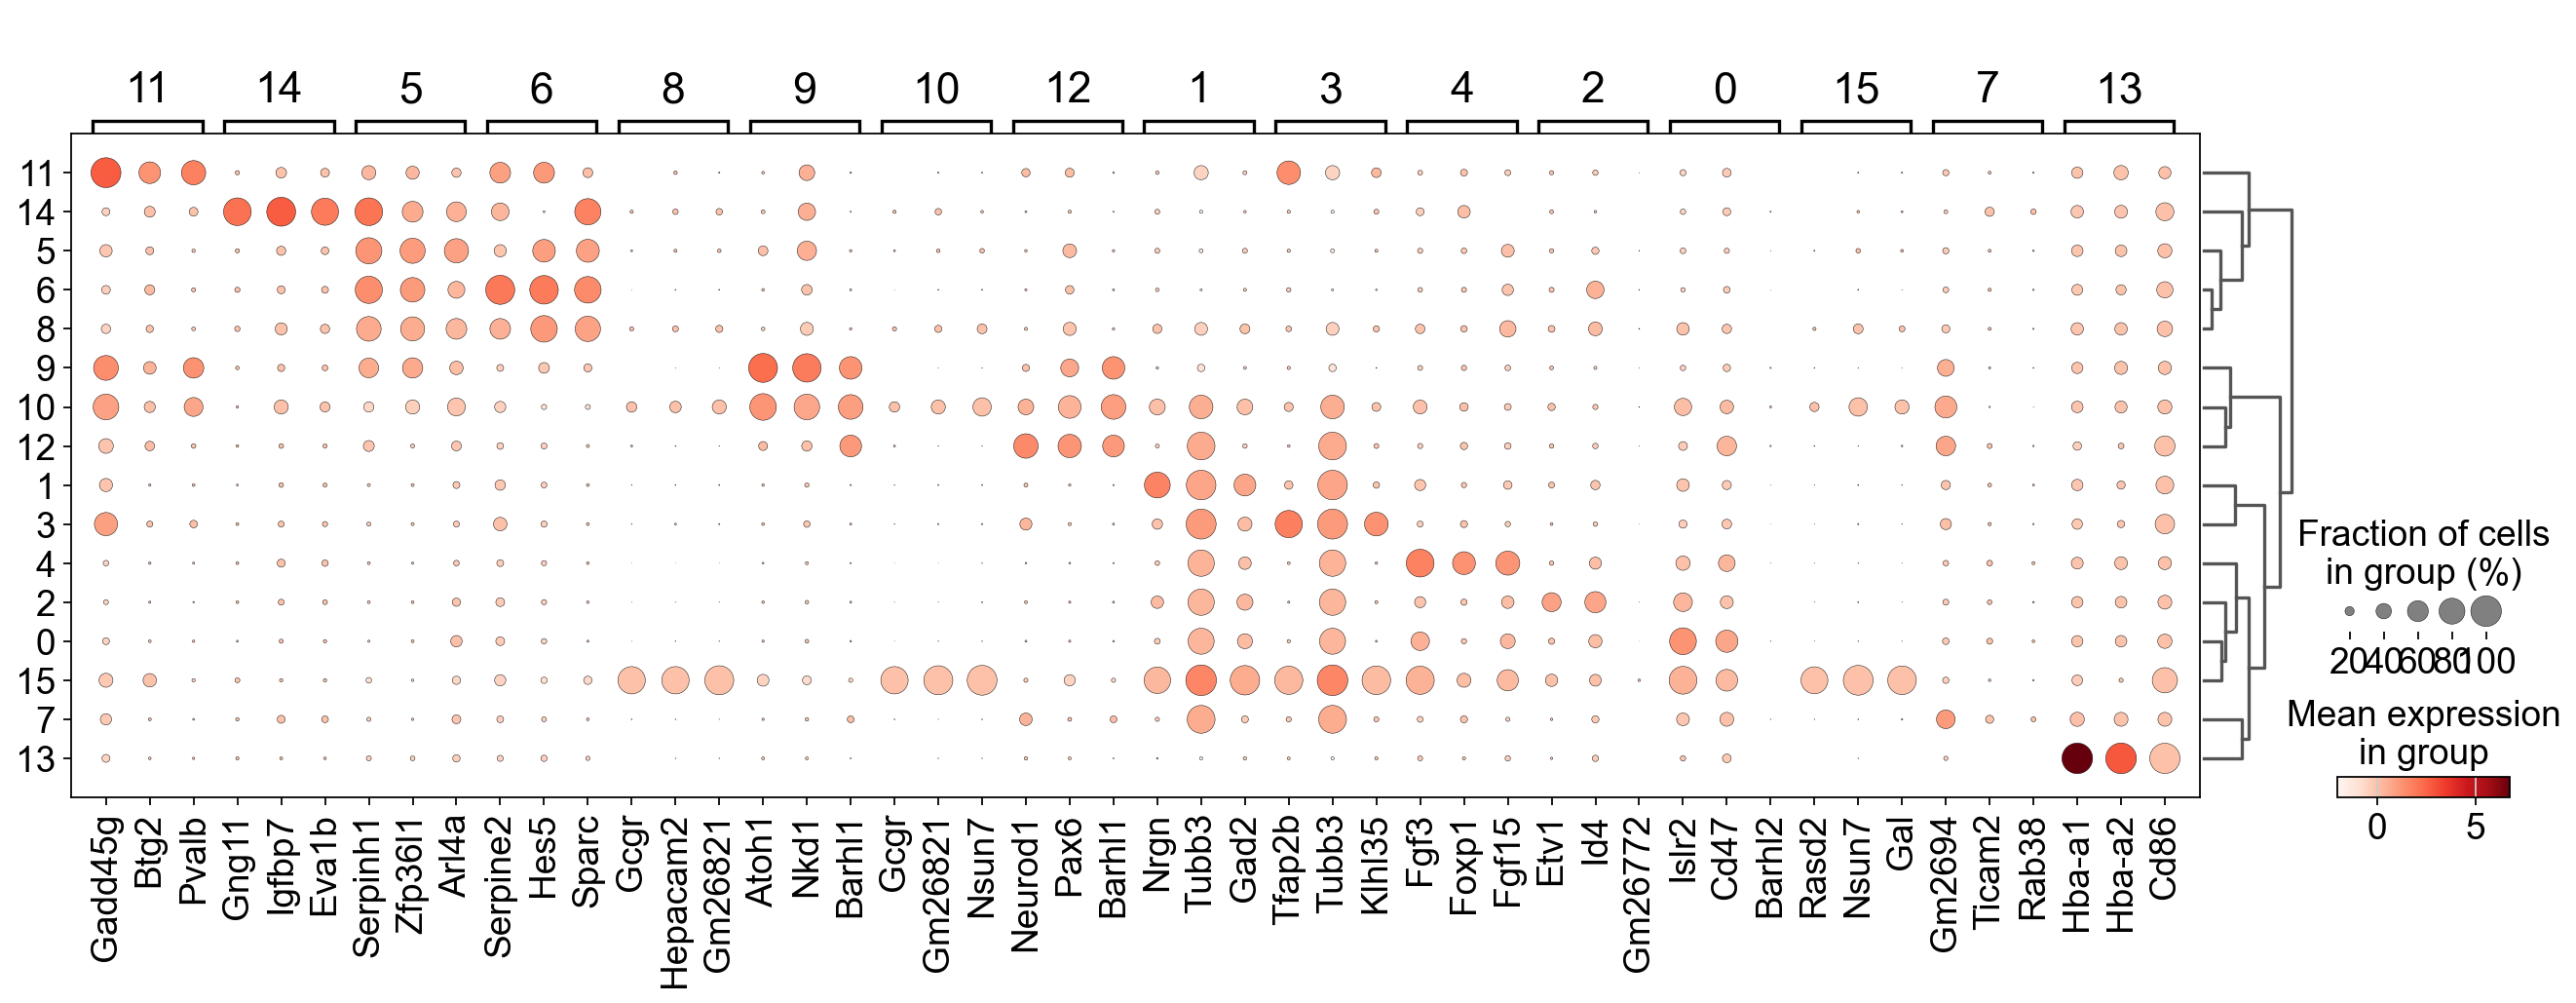

In [33]:
sc.set_figure_params(scanpy=True, fontsize=20) 
sc.pl.rank_genes_groups_dotplot(adata, use_raw=False, n_genes=3, key="wilcoxon", groupby="leiden")


In [34]:
marker_genes = pd.DataFrame(adata_raw_norm.uns["rank_genes_groups"]["names"])
marker_genes.iloc[:100].to_csv("most_variable.csv")

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_stacked_violin.py:324: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _color_df = _matrix.groupby(level=0).median()
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\jurri\miniconda3\Li

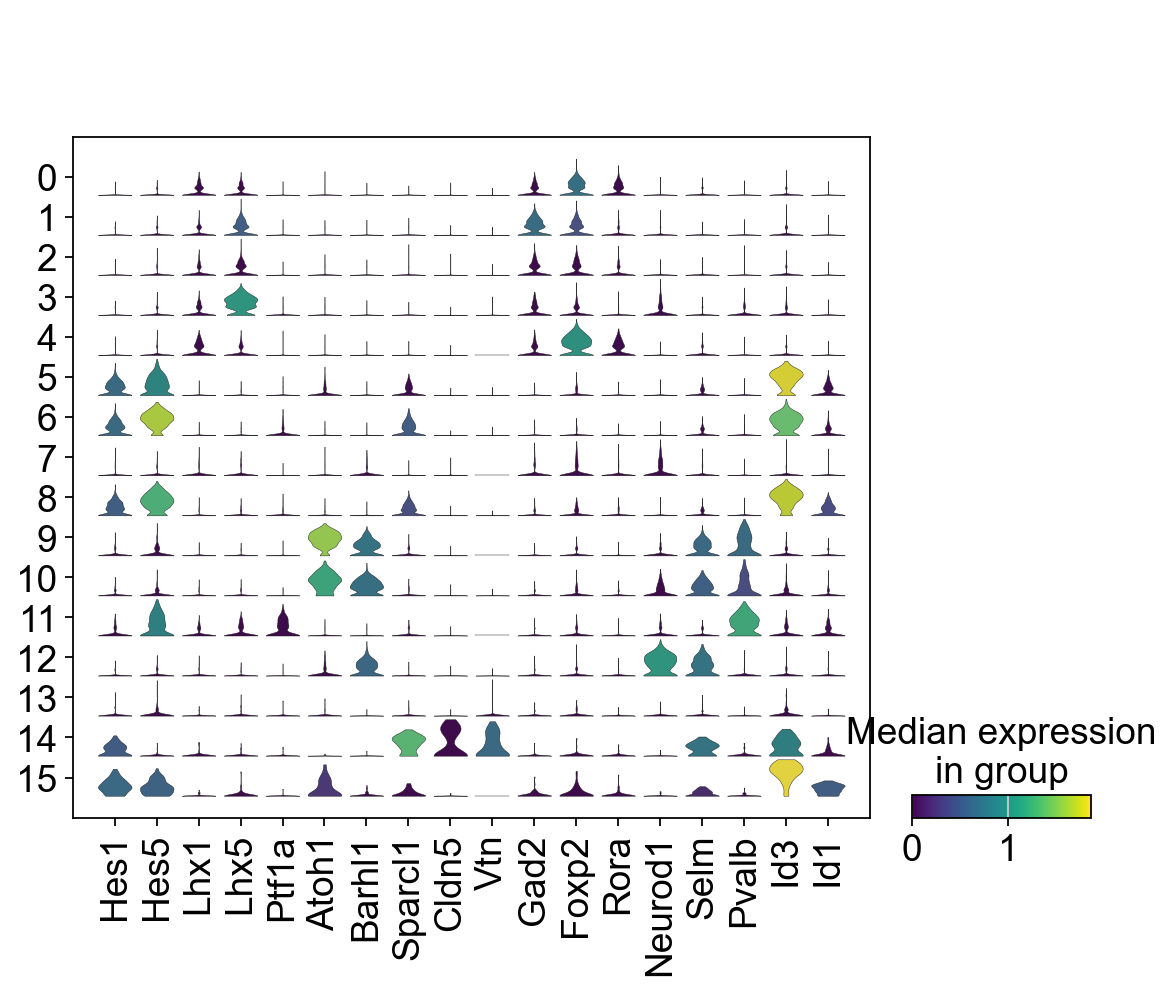

In [35]:
sc.pl.stacked_violin(
    adata_raw_norm, 
    [
        "Hes1", "Hes5", "Lhx1", "Lhx5", "Ptf1a", "Atoh1", 
        "Barhl1", "Sparcl1","Cldn5", "Vtn",
        "Gad2", "Foxp2", "Rora", "Neurod1", "Selm", "Pvalb", "Id3", "Id1"
    ], 
    groupby='leiden', 
    cmap='viridis',
    dendrogram=False,
    rotation=90,
    use_raw=False,
)

In [36]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6802724/ 
cluster2type_dict = {
    "0": "Gabaergic", 
    "1": "Gabaergic",
    "2": "Gabaergic",
    "3": "Gabaergic", 
    "4": "Purkinje",
    "5": "NPC",
    "6": "NPC",
    "7": "Granule neurons",
    "8": "NPC",
    "9": "glutamergic", 
    "10": "glutamergic",
    "11": "NPC gabaergic", 
    "12": "glutamergic",
    "13": "Other",
    "14": "NPC",
    "15": "NPC glutamergic",
}
cell_types = []
for key in cluster2type_dict:
    cell_types.append(cluster2type_dict[key])

In [37]:
adata.obs["cell_type"] = np.array([cluster2type_dict[i] for i in adata.obs["leiden"]])

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


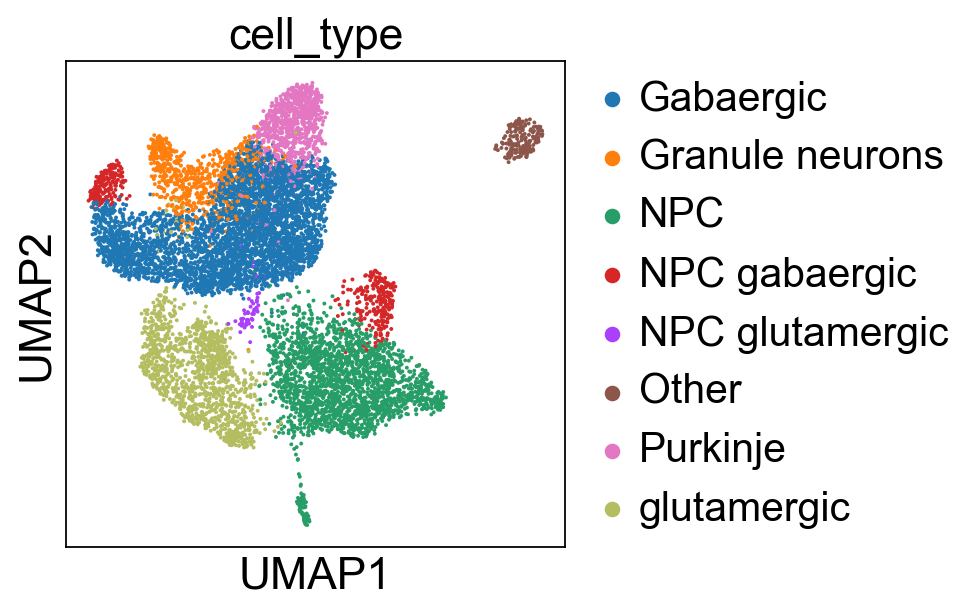

In [38]:
sc.pl.umap(adata, color=['cell_type'], use_raw=False, wspace=0.3, ncols=2)

## 8. Pseudo time analysis

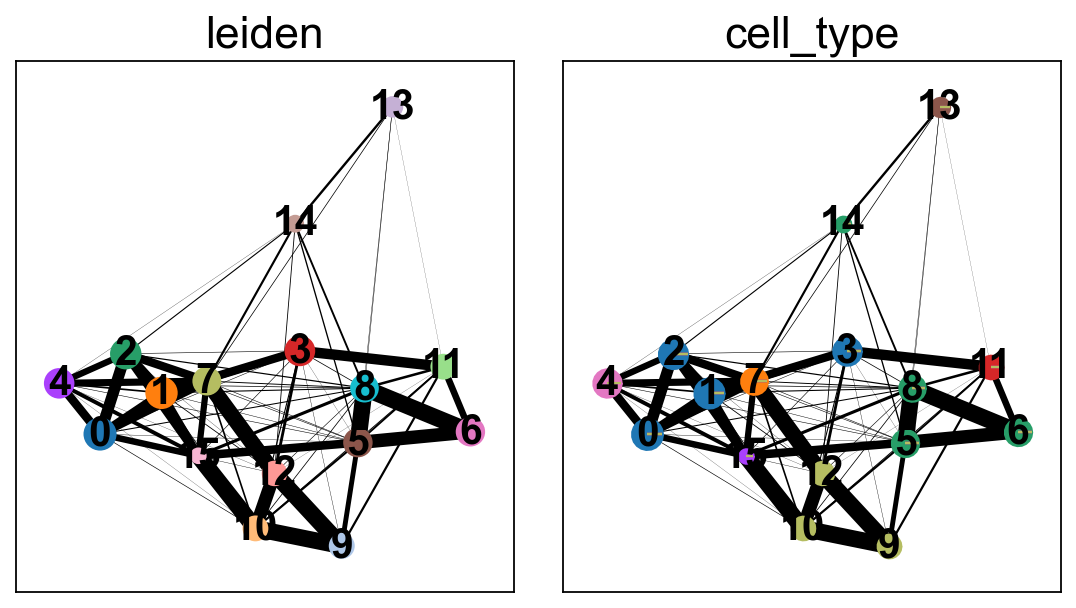

In [39]:
sc.tl.paga(adata, groups='leiden')
sc.pl.paga(adata, color=['leiden', 'cell_type'])


## 8.1 Gabaergic pseudotime


In [155]:
gaba = adata[
    (adata.obs["cell_type"] == "Gabaergic")
    | (adata.obs["cell_type"] == "Purkinje")
    | (adata.obs["cell_type"] == "NPC gabaergic"), :]

C:\Users\jurri\AppData\Local\Temp\ipykernel_52736\3698636052.py:2: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  gaba.uns['iroot'] = np.flatnonzero(gaba.obs['cell_type']  == 'NPC gabaergic')[4]
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


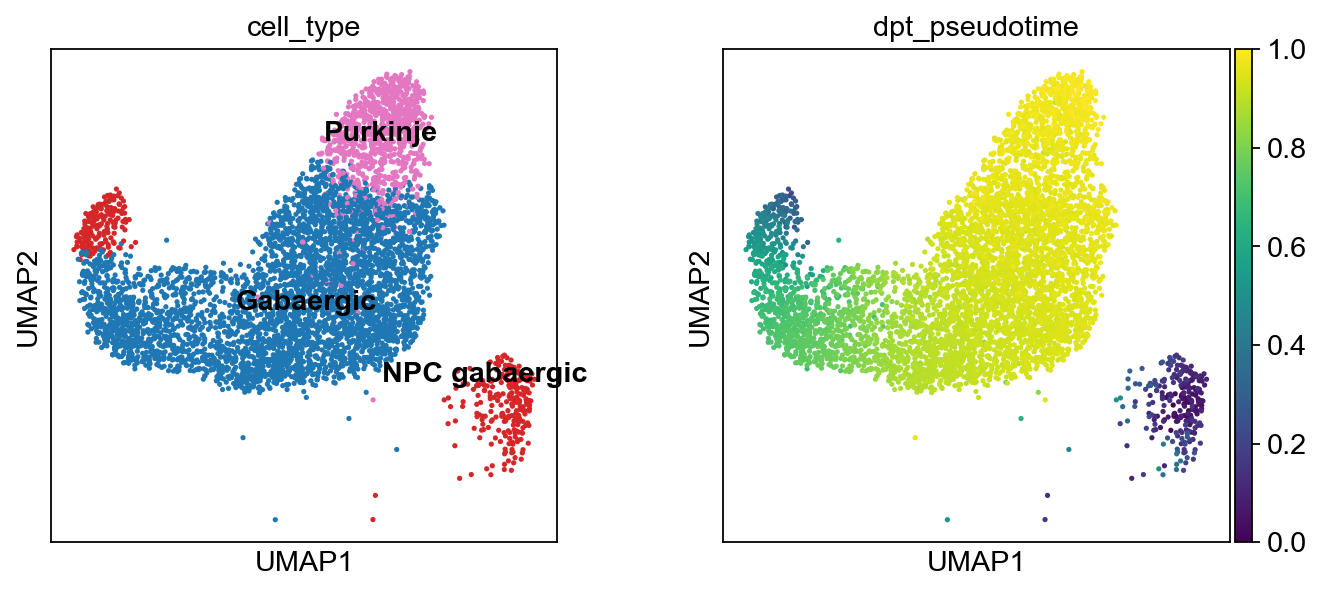

In [158]:
# Choose a root cel for diffusion
gaba.uns['iroot'] = np.flatnonzero(gaba.obs['cell_type']  == 'NPC gabaergic')[4]
sc.tl.diffmap(gaba)
sc.tl.dpt(gaba)
sc.pl.umap(gaba, color=['cell_type', 'dpt_pseudotime'], legend_loc='on data')

PLot the graph on which the above pseudotime is based

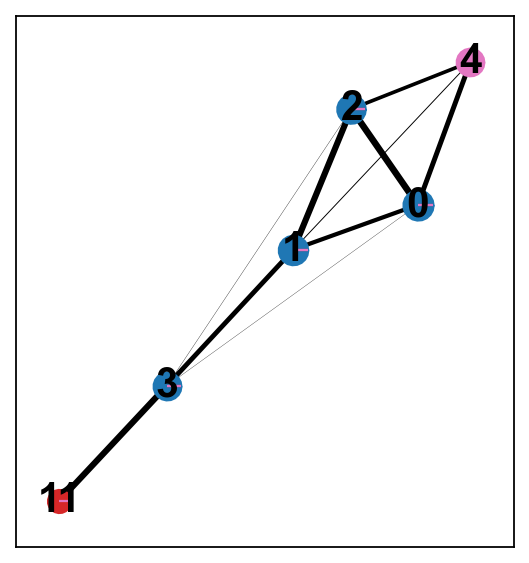

In [42]:
sc.tl.paga(gaba, groups='leiden')
sc.pl.paga(gaba, color=['cell_type'])

## 8.3 Follow markers genes
Here we will follow the expression of known marker genes through pseudotime

In [159]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9497131/
# https://www.antibodybeyond.com/reviews/cell-markers/purkinje-cell-marker.htm
# https://www.nature.com/articles/s41586-021-03220-z
marker_genes = {
    "Purkinje": [
        "Calb1",
        "Rora",
        "Foxp1",
#        "Foxp2", not there
        "Dab1",
        "Epha5",
        "Bcl11a",
        "Car8",
    ],
    "Gabaergic":[
        "Gad1",
        "Gad2",
        "Lhx5",
        "Tfap2a",
    ],
    "Interneuron dev":[
        "Ascl1", 
        "Neurog1",
        "Neurog2",
        "Tfap2b", 
    ]
}
all_genes = [gene for genes in marker_genes.values() for gene in genes]

In [72]:
gene_indices = [np.array([int(i), str(x)]) for i, x in enumerate(gaba.var.index) if x in all_genes]
mapper = dict()
for i, index in enumerate(gene_indices):
    mapper[i] = index[1]
gene_indices = np.array(gene_indices)
gene_indices_ = np.array(gene_indices[:, 0],dtype=int)
expression_of_markers = gaba.X[:, gene_indices_]
pseudo_time = gaba.obs["dpt_pseudotime"]

df = pd.DataFrame(expression_of_markers)
df = df.rename(columns=mapper)
df["pseudotime"] = pseudo_time

c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

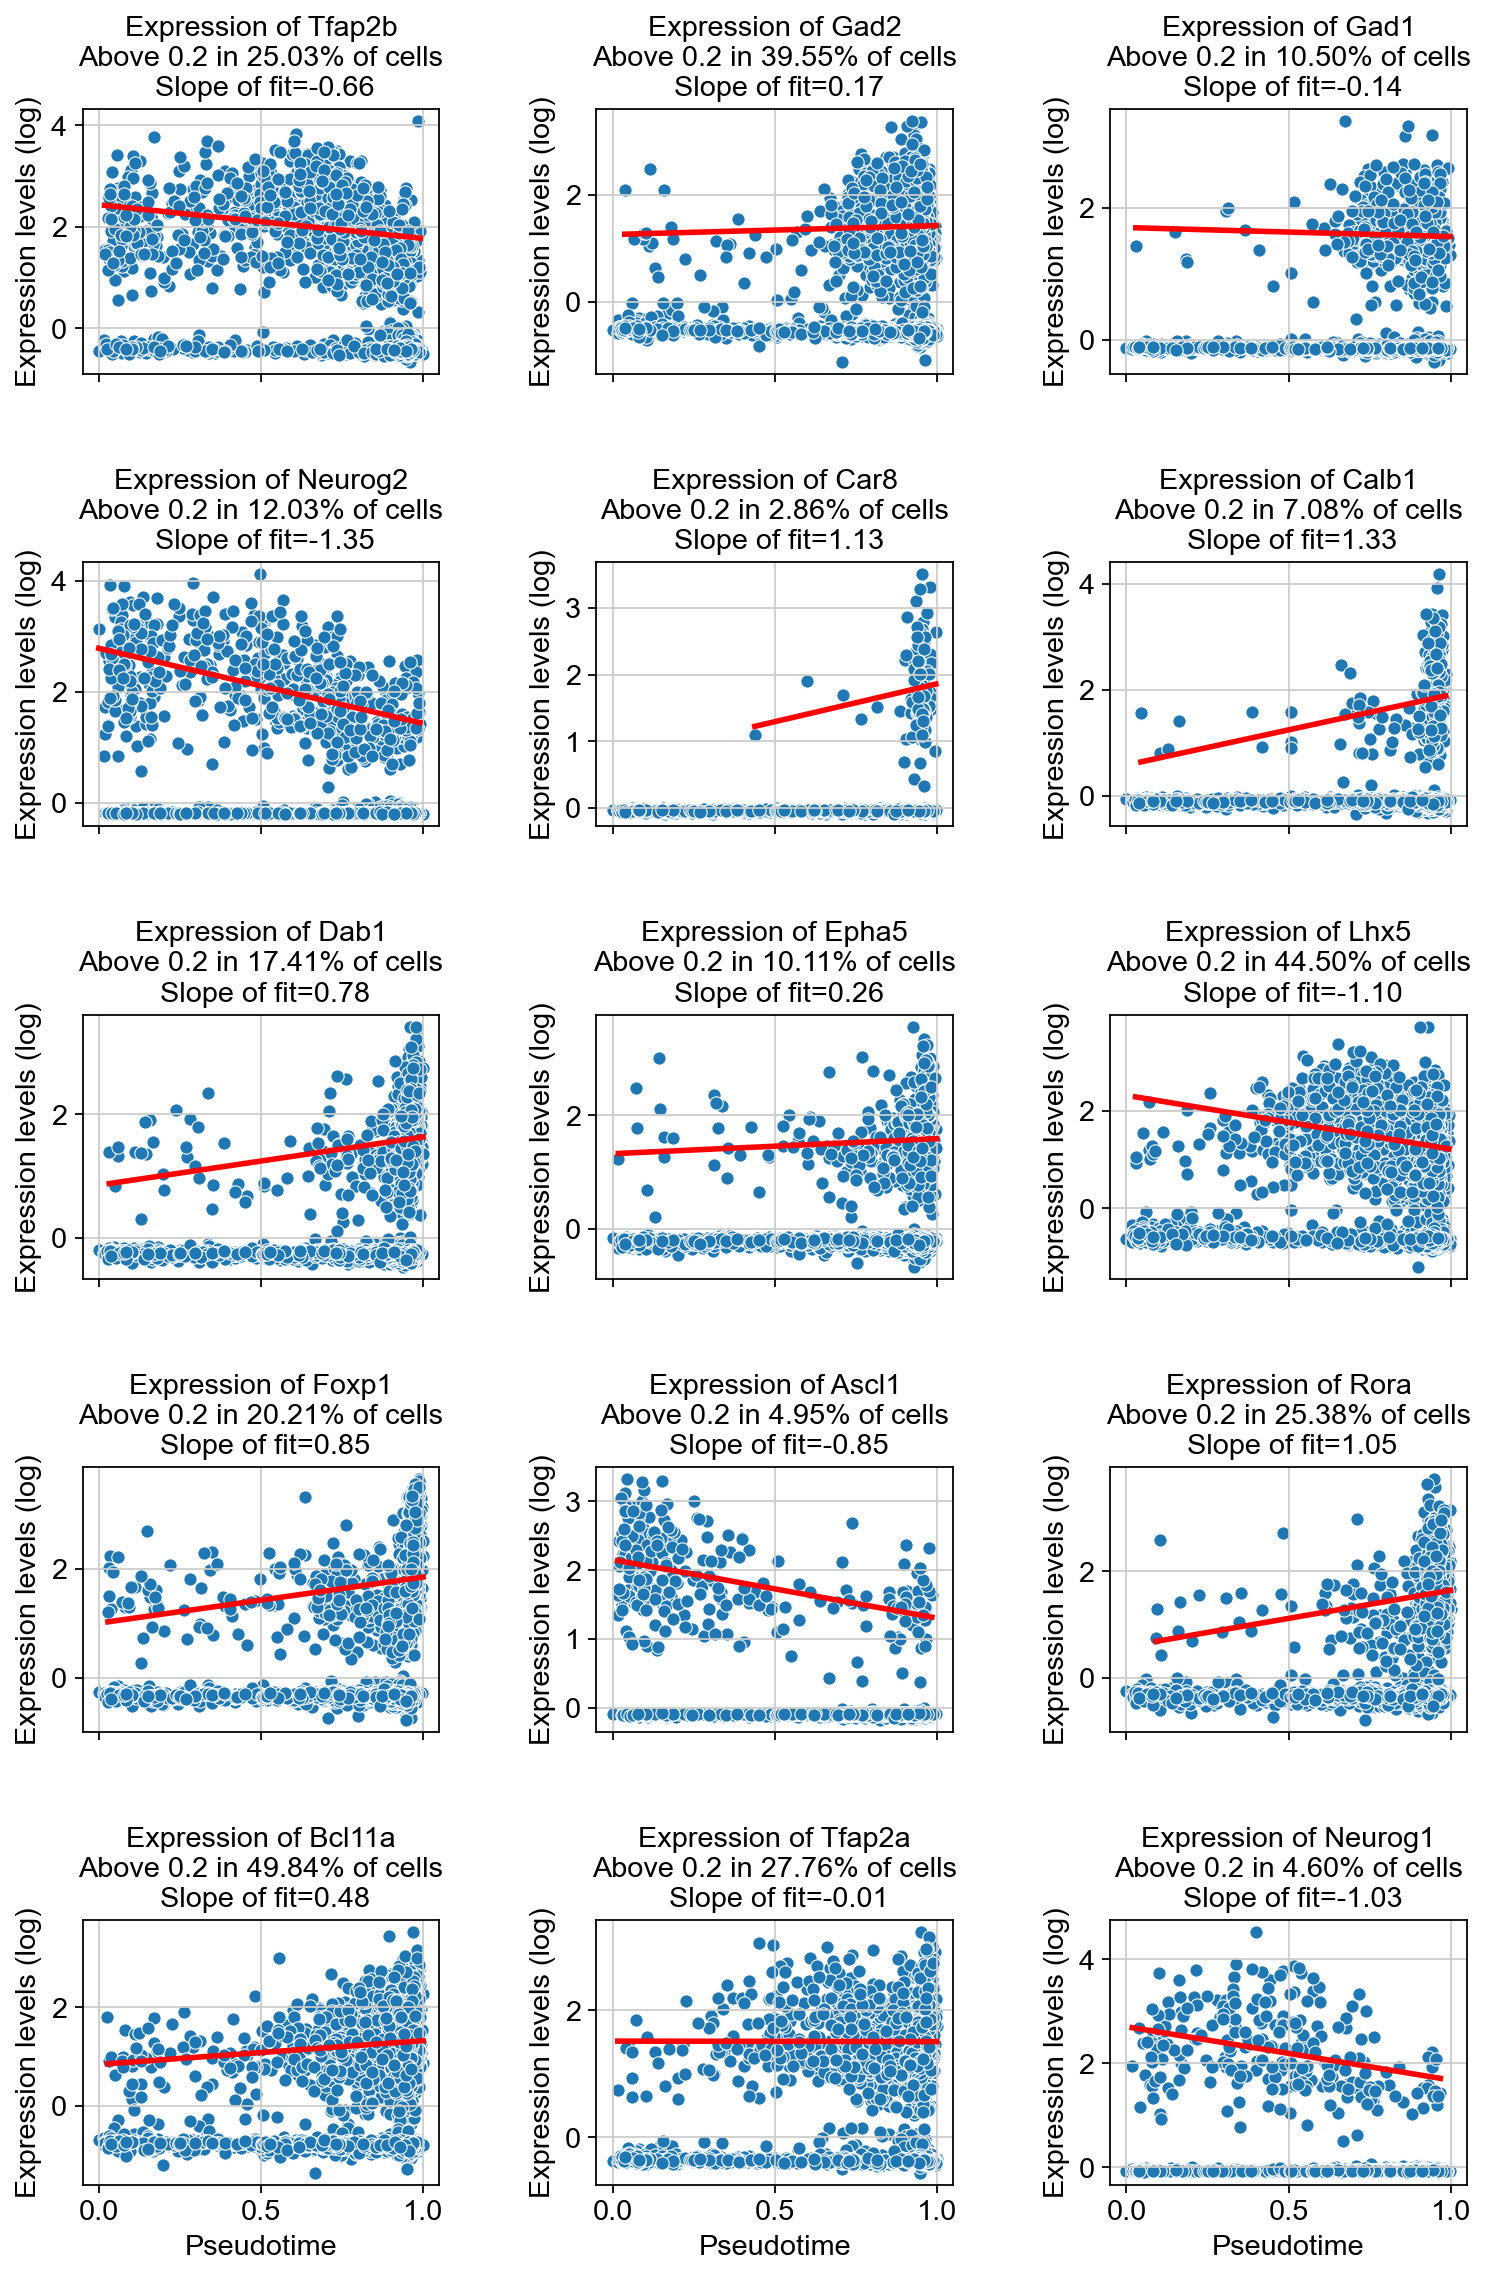

In [85]:
n_cols = 3
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(5, n_cols, sharex=True, sharey=False, figsize=(10,15))
threshold  = 0.2
for i in range(len(gene_indices)):
    x_plot = i % n_cols
    y_plot = int(np.floor(i/n_cols))
    # find marker type
    for group in marker_genes:
        if gene_indices[i, 1] in marker_genes[group]:
            break
    # count for how many cells expression is greater than 0.2
    expressed = np.sum(expression_of_markers[:, i] > threshold)/len(expression_of_markers[:, i])*100
    # above zero
    above_zero = expression_of_markers[:, i] > threshold
    
    # make model
    X = pseudo_time[above_zero]
    X = sm.add_constant(X)
    y = expression_of_markers[above_zero, i]
    mod = sm.OLS(y, X) 
    res = mod.fit()
    coeff = res.params.dpt_pseudotime
    intercept = res.params.const
    # do plotting
    sns.scatterplot(x=pseudo_time[:], y=expression_of_markers[:, i], ax=axs[y_plot, x_plot], markers='x')
    sns.lineplot(x=pseudo_time[above_zero], y=pseudo_time[above_zero]*coeff+intercept, ax=axs[y_plot, x_plot], color='red', linewidth=2.5)
    # set titles
    axs[y_plot, x_plot].set_title(f"Expression of {gene_indices[i, 1]}\nAbove 0.2 in {expressed:.2f}% of cells\n Slope of fit={coeff:.2f}")
    axs[y_plot, x_plot].set_ylabel("Expression levels (log)")
    axs[y_plot, x_plot].set_xlabel("Pseudotime")

fig.tight_layout()
plt.show()

c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with

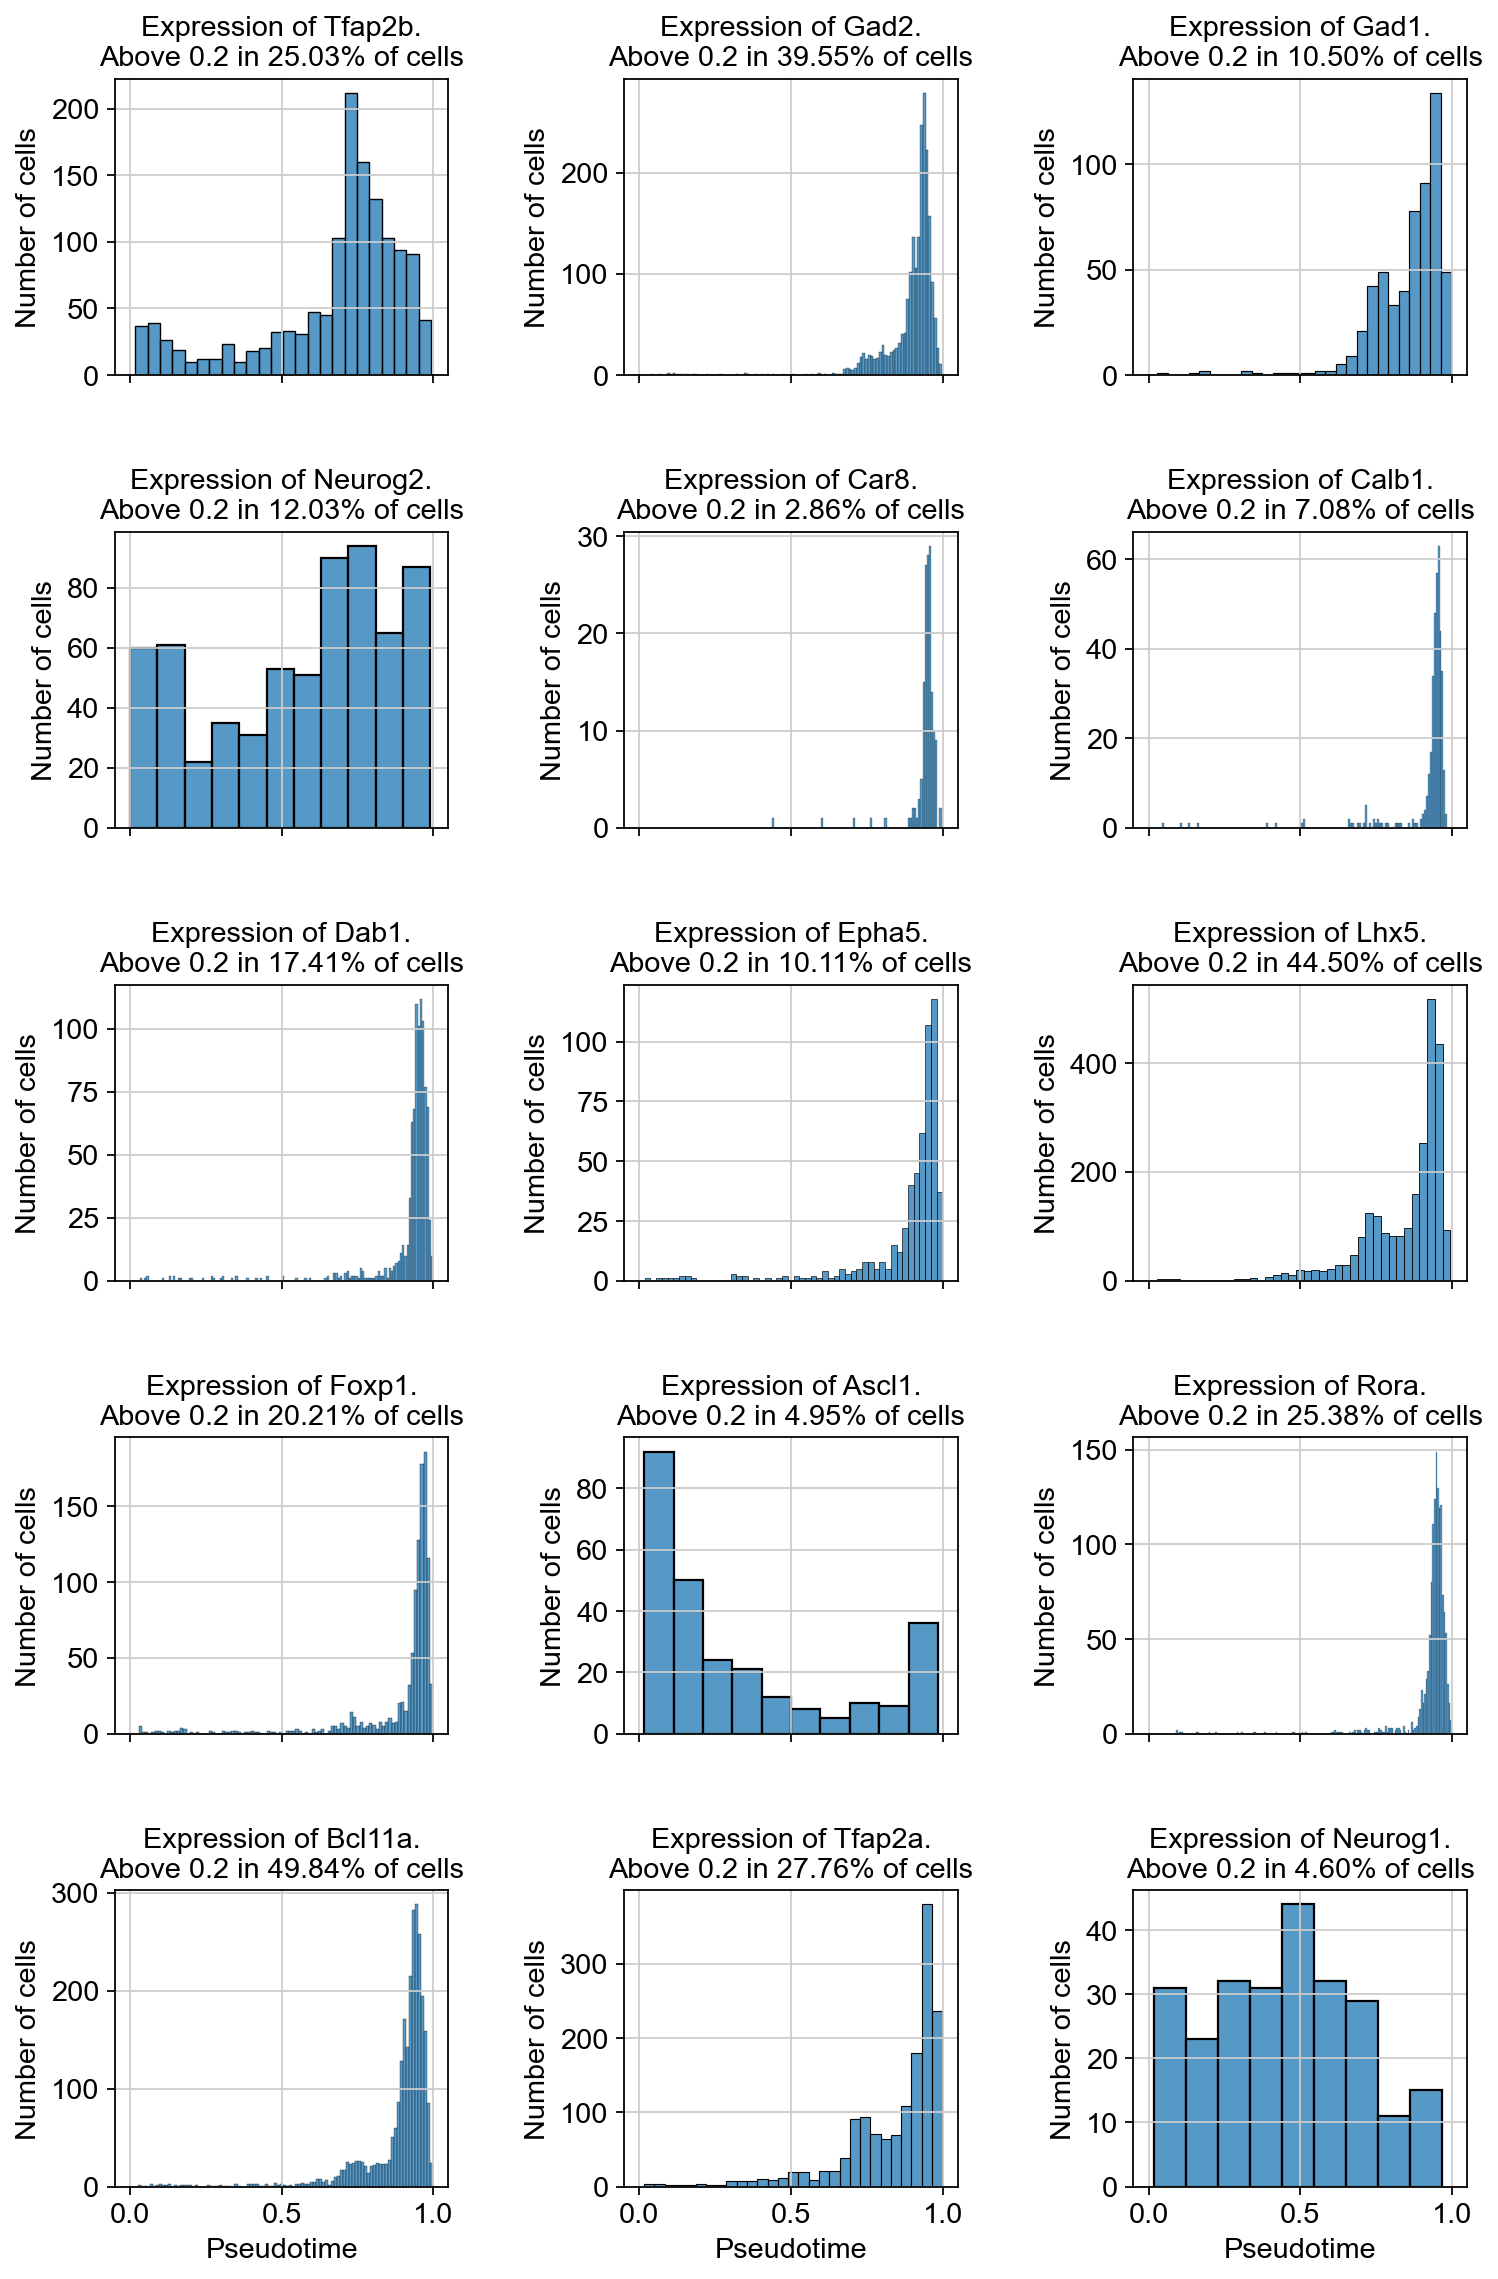

In [86]:
n_cols = 3
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(5, n_cols, sharex=True, sharey=False, figsize=(10,15))
threshold  = 0.2
for i in range(len(gene_indices)):
    x_plot = i % n_cols
    y_plot = int(np.floor(i/n_cols))
    # find marker type
    for group in marker_genes:
        if gene_indices[i, 1] in marker_genes[group]:
            break
    # count for how many cells expression is greater than 0.2
    expressed = np.sum(expression_of_markers[:, i] > threshold)/len(expression_of_markers[:, i])*100
    # above zero
    above_zero = expression_of_markers[:, i] > threshold
    
    # make model
    X = pseudo_time[above_zero]
    X = sm.add_constant(X)
    y = expression_of_markers[above_zero, i]
    mod = sm.OLS(y, X) 
    res = mod.fit()
    coeff = res.params.dpt_pseudotime
    intercept = res.params.const
    # do plotting
    sns.histplot(x=pseudo_time[above_zero], ax=axs[y_plot, x_plot])
    # set titles
    axs[y_plot, x_plot].set_title(f"Expression of {gene_indices[i, 1]}.\nAbove 0.2 in {expressed:.2f}% of cells")
    axs[y_plot, x_plot].set_ylabel("Number of cells")
    axs[y_plot, x_plot].set_xlabel("Pseudotime")

fig.tight_layout()
plt.show()

In [156]:
gaba_binary = gaba.copy()
gaba_binary.X = gaba_binary.X > 0.02

In [122]:
gene_indices

array([['2', 'Tfap2b'],
       ['143', 'Gad2'],
       ['189', 'Gad1'],
       ['433', 'Neurog2'],
       ['459', 'Car8'],
       ['464', 'Calb1'],
       ['503', 'Dab1'],
       ['620', 'Epha5'],
       ['658', 'Lhx5'],
       ['765', 'Foxp1'],
       ['1017', 'Ascl1'],
       ['1258', 'Rora'],
       ['1332', 'Bcl11a'],
       ['1484', 'Tfap2a'],
       ['1500', 'Neurog1']], dtype='<U11')

In [135]:
calb1_index = gaba_binary.X[:, 464]
tfap2a_index = gaba_binary.X[:, 1484]
tfap2b_index = gaba_binary.X[:, 2]
Gad2_index = gaba_binary.X[:, 143]
Foxp1_index = gaba_binary.X[:, 765]
Neurog1_index = gaba_binary.X[:, 1500]

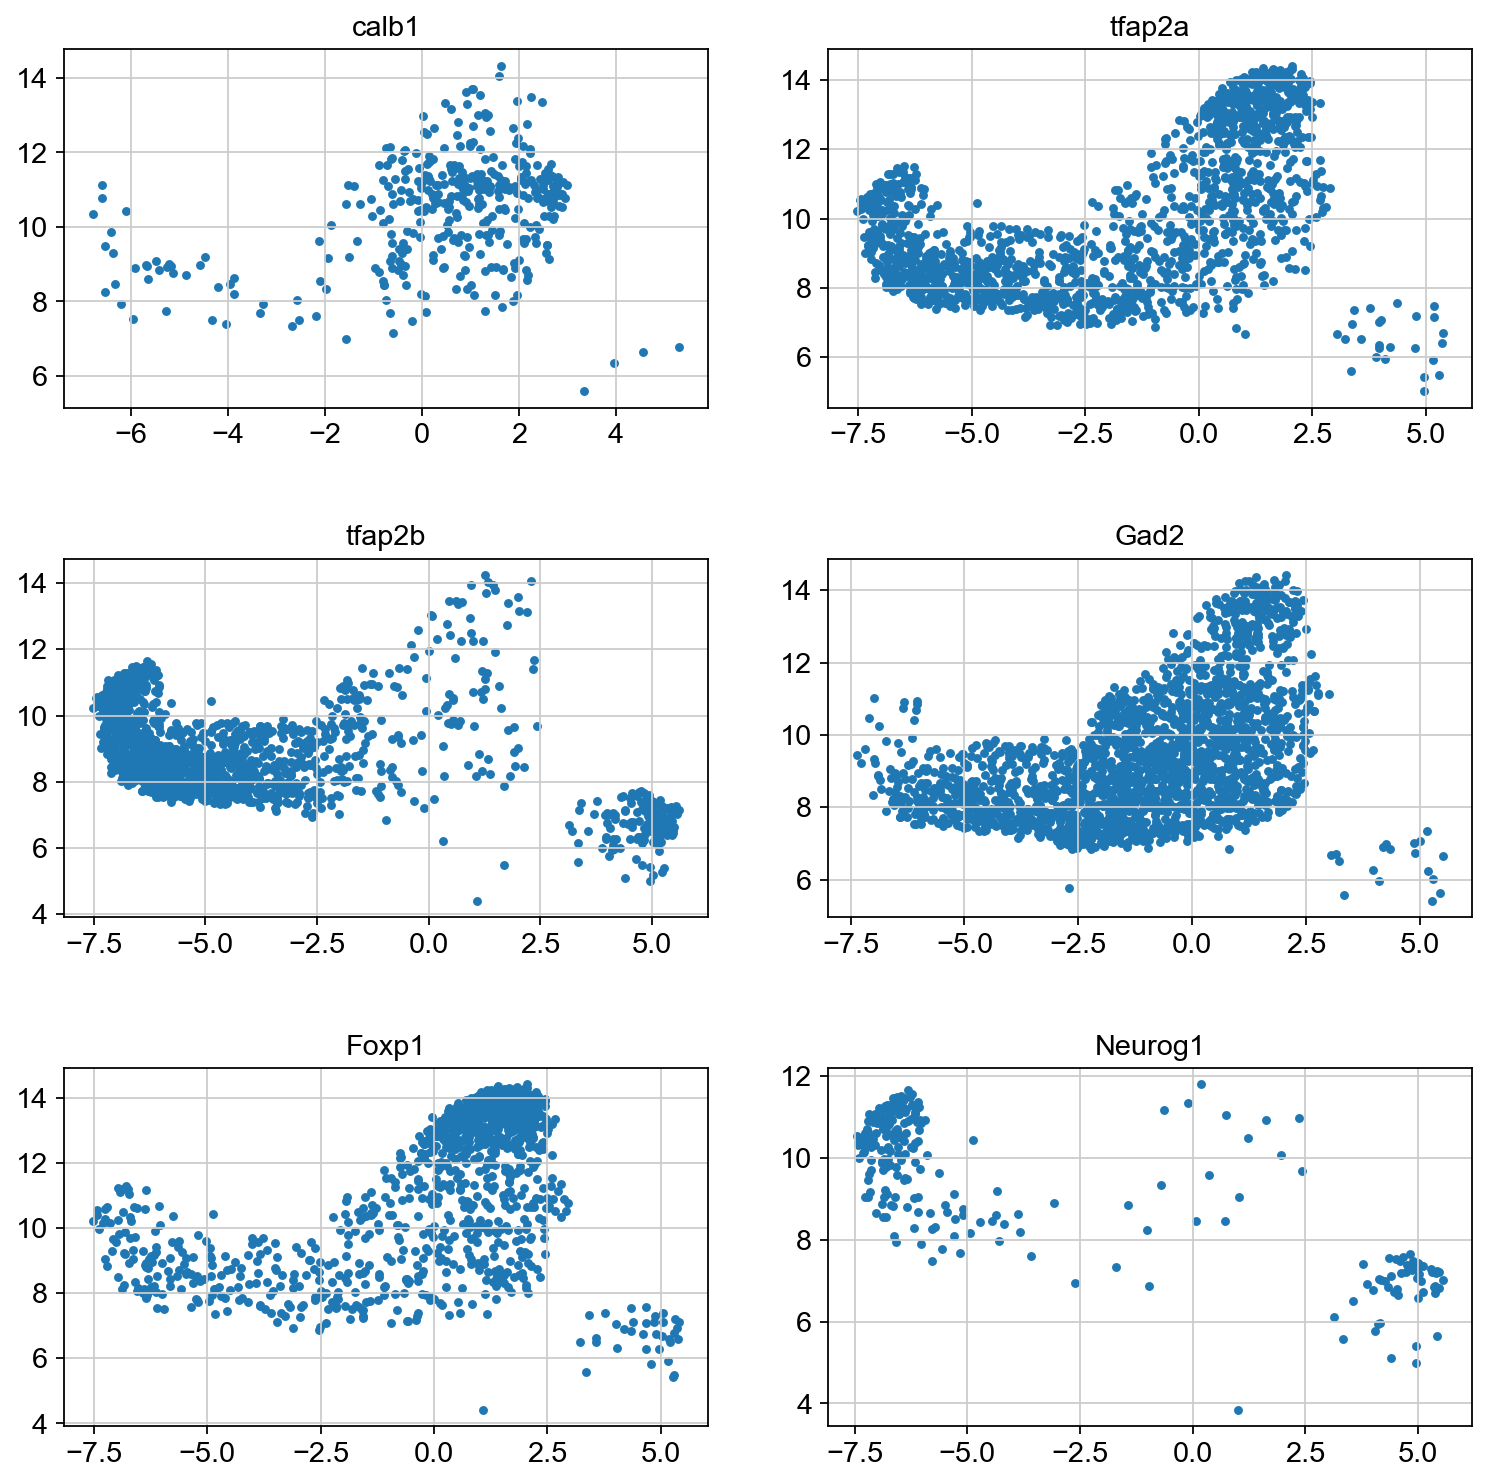

In [136]:
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(3,2, figsize=(10,10))
axs[0,0].scatter(gaba_binary.obsm["X_umap"][calb1_index,0], gaba_binary.obsm["X_umap"][calb1_index,1], marker='.')
axs[0,0].set_title("calb1")
axs[0,1].scatter(gaba_binary.obsm["X_umap"][tfap2a_index,0], gaba_binary.obsm["X_umap"][tfap2a_index,1], marker='.')
axs[0,1].set_title("tfap2a")
axs[1,0].scatter(gaba_binary.obsm["X_umap"][tfap2b_index,0], gaba_binary.obsm["X_umap"][tfap2b_index,1], marker='.')
axs[1,0].set_title("tfap2b")
axs[1,1].scatter(gaba_binary.obsm["X_umap"][Gad2_index,0], gaba_binary.obsm["X_umap"][Gad2_index,1], marker='.')
axs[1,1].set_title("Gad2")
axs[2,0].scatter(gaba_binary.obsm["X_umap"][Foxp1_index,0], gaba_binary.obsm["X_umap"][Foxp1_index,1], marker='.')
axs[2,0].set_title("Foxp1")
axs[2,1].scatter(gaba_binary.obsm["X_umap"][Neurog1_index,0], gaba_binary.obsm["X_umap"][Neurog1_index,1], marker='.')
axs[2,1].set_title("Neurog1")
fig.tight_layout()

plt.show()

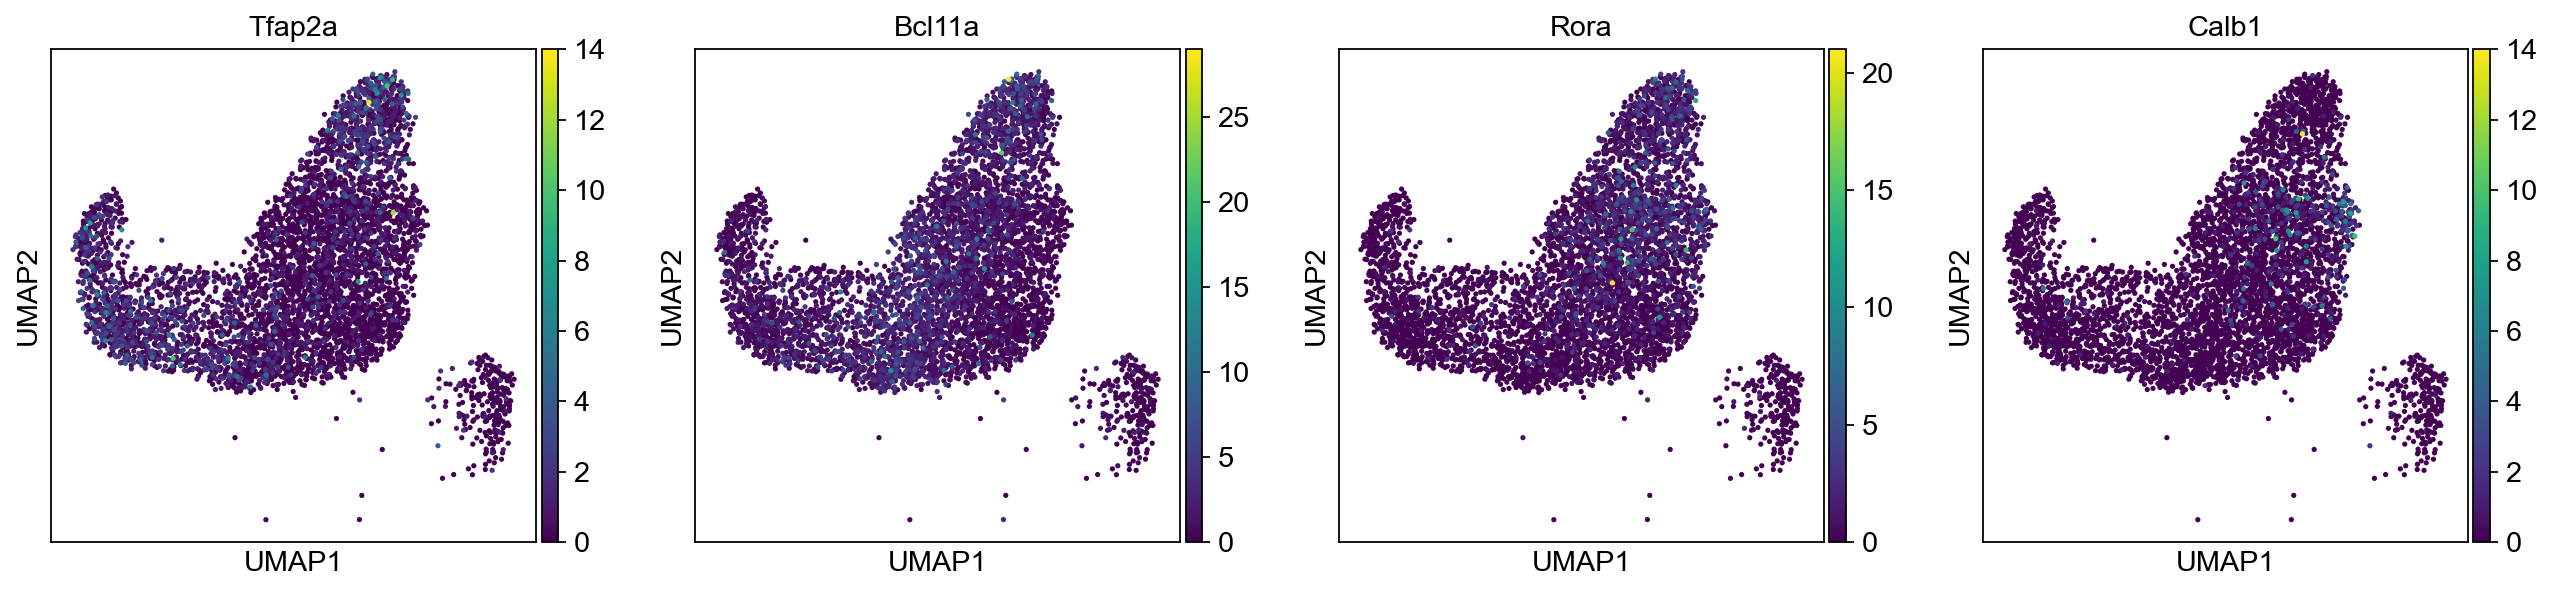

In [92]:
sc.pl.umap(gaba_binary, color=['Tfap2a', 'Bcl11a', 'Rora', 'Calb1'], legend_loc='on data')

## 8.3 Based on the above, narrow down the groups further

In [160]:
gaba.obs["late_early"] = gaba.obs["dpt_pseudotime"]
gaba.obs["late_early"][gaba.obs["dpt_pseudotime"] < 0.2] = "early"
gaba.obs["late_early"][gaba.obs["dpt_pseudotime"] > 0.8] = "late"
gaba.obs["late_early"] = gaba.obs["late_early"].astype("category")
late_early = gaba[(gaba.obs["late_early"] == "late") | (gaba.obs["late_early"] == "early"), :]

C:\Users\jurri\AppData\Local\Temp\ipykernel_52736\228209456.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaba.obs["late_early"][gaba.obs["dpt_pseudotime"] < 0.2] = "early"
C:\Users\jurri\AppData\Local\Temp\ipykernel_52736\228209456.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'early' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  gaba.obs["late_early"][gaba.obs["dpt_pseudotime"] < 0.2] = "early"


c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
c:\Users\jurri\miniconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:1

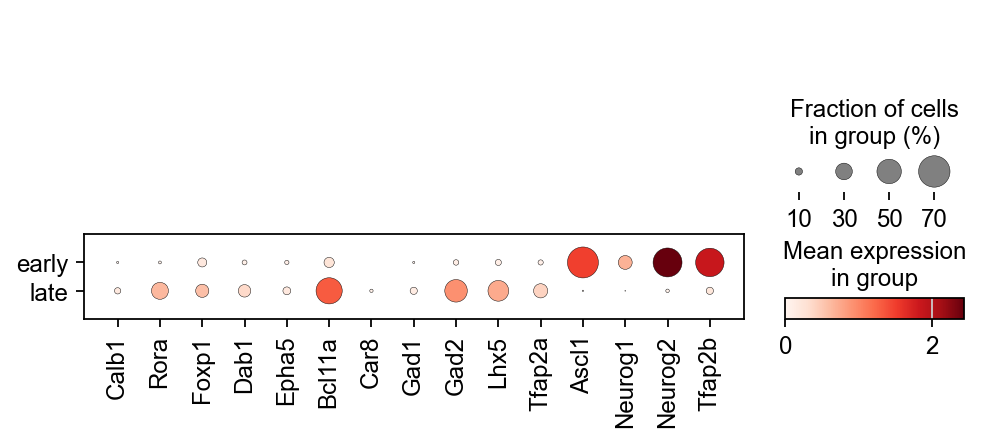

In [167]:
sc.tl.rank_genes_groups(late_early , 'late_early', use_raw=False, method='wilcoxon', key_added = "wilcoxon")
sc.pl.dotplot(late_early, all_genes, groupby='late_early')

c:\Users\jurri\miniconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default 

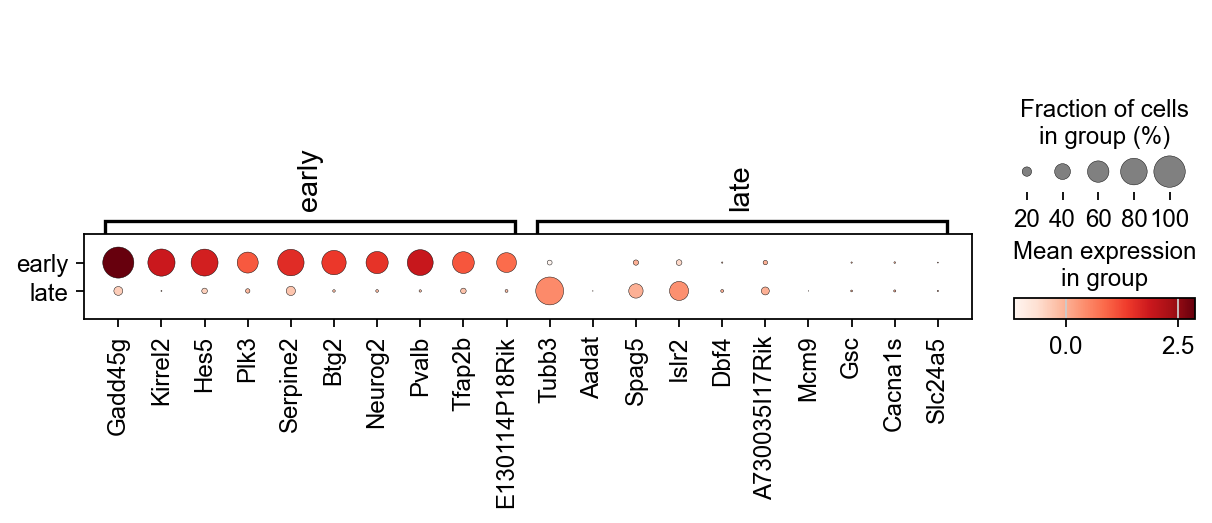

In [185]:
sc.tl.rank_genes_groups(late_early, 'late_early', use_raw=False, method='wilcoxon', key_added = "wilcoxon")

sc.pl.rank_genes_groups_dotplot(late_early, use_raw=False, n_genes=10, key="wilcoxon", groupby="late_early")

In [168]:
late_early.obs['late_early'].value_counts()
# downsample

late_early
late     4259
early     204
Name: count, dtype: int64

In [169]:
target_cells = 200
tmp = [late_early[late_early.obs['late_early'] == s] for s in late_early.obs['late_early'].cat.categories]

for dat in tmp:
    if dat.n_obs > target_cells:
         sc.pp.subsample(dat, n_obs=target_cells)

late_early_sampled = tmp[0].concatenate(*tmp[1:])
late_early_sampled.obs['late_early'].value_counts()

C:\Users\jurri\AppData\Local\Temp\ipykernel_52736\3170296926.py:8: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  late_early_sampled = tmp[0].concatenate(*tmp[1:])


late_early
early    200
late     200
Name: count, dtype: int64

## 8.4 Compare early to late

In [172]:
# get gene lists of interest
comparments = {}
processes = {}
for cat in late_early.obs["late_early"].unique():
    glist = sc.get.rank_genes_groups_df(late_early, group=cat, 
                                    key='wilcoxon', log2fc_min=0.5, 
                                    pval_cutoff=0.05)['names'].squeeze().str.strip().tolist()
    print(f"For category {cat} consider {len(glist)} genes")
    if glist:
        comparments[cat] = gseapy.enrichr(gene_list=glist,
                        organism='Mouse',
                        gene_sets='GO_Cellular_Component_2023',
                        background=late_early.var.index.to_list(),
                        cutoff = 0.5)
        processes[cat] = gseapy.enrichr(gene_list=glist,
                        organism='Mouse',
                        gene_sets='GO_Biological_Process_2023',
                         background=late_early.var.index.to_list(),
                        cutoff = 0.5)
    

For category late consider 96 genes
For category early consider 338 genes


In [178]:
comparments["early"].results.head(10)

Gene_set  \
0  GO_Cellular_Component_2023   
1  GO_Cellular_Component_2023   
2  GO_Cellular_Component_2023   
3  GO_Cellular_Component_2023   
4  GO_Cellular_Component_2023   
5  GO_Cellular_Component_2023   
6  GO_Cellular_Component_2023   
7  GO_Cellular_Component_2023   
8  GO_Cellular_Component_2023   
9  GO_Cellular_Component_2023   

                                                Term   P-value  \
0             Bicellular Tight Junction (GO:0005923)  0.034999   
1               Apical Junction Complex (GO:0043296)  0.054554   
2                        Tight Junction (GO:0070160)  0.054554   
3                 Core Mediator Complex (GO:0070847)  0.141771   
4          Mitochondrial Inner Membrane (GO:0005743)  0.158422   
5  Intracellular Cyclic Nucleotide Activated Cati...  0.173779   
6               Large Ribosomal Subunit (GO:0015934)  0.173779   
7      HFE-transferrin Receptor Complex (GO:1990712)  0.173779   
8                Mitochondrial Ribosome (GO:0005761)  0.173779   
9  U2-type Catalytic Step 2 Spliceosome (GO:0071007)  0.173779   

   Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0           0.99789            0                     0    4.799401   
1           0.99789            0                     0    3.837126   
2           0.99789            0                     0    3.837126   
3           0.99789            0                     0    4.776786   
4           0.99789            0                     0    1.995746   
5           0.99789            0                     0         inf   
6           0.99789            0                     0         inf   
7           0.99789            0                     0         inf   
8           0.99789            0                     0         inf   
9           0.99789            0                     0         inf   

   Combined Score                               Genes  
0       16.089685             CLDN11;CLMP;EPCAM;MAGI2  
1       11.160504             CLDN11;CLMP;EPCAM;MAGI2  
2       11.160504             CLDN11;CLMP;EPCAM;MAGI2  
3        9.331654                         MED30;MED31  
4        3.677143  SLC25A27;SLC25A32;SDSL;MRPL43;GCAT  
5             inf                               CNGB1  
6             inf                                RPL6  
7             inf                                  F3  
8             inf                              MRPL43  
9             inf                                DHX8

In [179]:
comparments["late"].results.head(10)

Gene_set  \
0  GO_Cellular_Component_2023   
1  GO_Cellular_Component_2023   
2  GO_Cellular_Component_2023   
3  GO_Cellular_Component_2023   
4  GO_Cellular_Component_2023   
5  GO_Cellular_Component_2023   
6  GO_Cellular_Component_2023   
7  GO_Cellular_Component_2023   
8  GO_Cellular_Component_2023   
9  GO_Cellular_Component_2023   

                                                Term   P-value  \
0                              Lysosome (GO:0005764)  0.001246   
1  Collagen-Containing Extracellular Matrix (GO:0...  0.001797   
2      Low-Density Lipoprotein Particle (GO:0034362)  0.002412   
3     High-Density Lipoprotein Particle (GO:0034364)  0.007003   
4           Cortical Actin Cytoskeleton (GO:0030864)  0.007003   
5                 Cortical Cytoskeleton (GO:0030863)  0.013555   
6                         Lytic Vacuole (GO:0000323)  0.017457   
7                    Actin Cytoskeleton (GO:0015629)  0.020848   
8                          Cytoskeleton (GO:0005856)  0.028245   
9                        Vacuolar Lumen (GO:0005775)  0.028530   

   Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0          0.076379            0                     0    4.452088   
1          0.076379            0                     0    3.467054   
2          0.076379            0                     0         inf   
3          0.133049            0                     0   39.319149   
4          0.133049            0                     0   39.319149   
5          0.214624            0                     0   19.648936   
6          0.232074            0                     0    4.685422   
7          0.232074            0                     0    3.573391   
8          0.232074            0                     0    2.868254   
9          0.232074            0                     0    5.390029   

   Combined Score                                              Genes  
0       29.773950         IFITM3;RAMP2;ANXA2;BGN;ECE1;CD34;CTSC;SNX6  
1       21.916855  GDF10;EGFL7;LGALS1;CCDC80;ANXA2;COL4A2;BGN;APO...  
2             inf                                        APOE;PLA2G7  
3      195.081141                                        APOE;PLA2G7  
4      195.081141                                       CLDN5;SLC2A1  
5       84.509826                                       CLDN5;SLC2A1  
6       18.966728                               RAMP2;CD34;CTSC;SNX6  
7       13.830822                    CLDN5;FLT1;ONECUT2;SLC2A1;SPRY2  
8       10.230567              FLT1;ONECUT2;PRC1;MTCL1;EPB41L2;SPRY2  
9       19.171185                                     ANXA2;BGN;CTSC

In [180]:
processes["early"].results.head(10)

Gene_set  \
0  GO_Biological_Process_2023   
1  GO_Biological_Process_2023   
2  GO_Biological_Process_2023   
3  GO_Biological_Process_2023   
4  GO_Biological_Process_2023   
5  GO_Biological_Process_2023   
6  GO_Biological_Process_2023   
7  GO_Biological_Process_2023   
8  GO_Biological_Process_2023   
9  GO_Biological_Process_2023   

                                                Term   P-value  \
0  Regulation Of Osteoclast Differentiation (GO:0...  0.005209   
1  Negative Regulation Of Osteoclast Differentiat...  0.005209   
2         Regulation Of Bone Resorption (GO:0045124)  0.005209   
3  Regulation Of Actin Filament Polymerization (G...  0.005462   
4  Regulation Of Innate Immune Response (GO:0045088)  0.010034   
5  Negative Regulation Of Immune Response (GO:005...  0.010034   
6  Positive Regulation Of Response To Biotic Stim...  0.010034   
7  Regulation Of Intracellular Signal Transductio...  0.011377   
8  Nuclear-Transcribed mRNA Catabolic Process, De...  0.018142   
9  Positive Regulation Of DNA Damage Response, Si...  0.018142   

   Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0          0.701964            0                     0         inf   
1          0.701964            0                     0         inf   
2          0.701964            0                     0         inf   
3          0.701964            0                     0    8.028028   
4          0.701964            0                     0    9.610778   
5          0.701964            0                     0    9.610778   
6          0.701964            0                     0    9.610778   
7          0.701964            0                     0    2.851506   
8          0.701964            0                     0   14.382090   
9          0.701964            0                     0   14.382090   

   Combined Score                                              Genes  
0             inf                                  CCL3;CARTPT;FSTL3  
1             inf                                  CCL3;CARTPT;FSTL3  
2             inf                                  CSF1R;SPP1;CARTPT  
3       41.825939                        ALOX15;ESAM;PAK3;PFN3;KANK3  
4       44.226798                           DHX58;POLR3G;TREM2;IRAK3  
5       44.226798                           DHX58;ALOX15;TREM2;IRAK3  
6       44.226798                            CD180;MMRN2;LY86;POLR3G  
7       12.763732  ARHGAP11A;RASD2;NTRK1;TIAM1;CSF1R;ATM;TREM2;PA...  
8       57.665407                                  PAN2;EXOSC8;RC3H2  
9       57.665407                                      ATM;MSX1;HIC1

In [181]:
processes["late"].results.head(10)

Gene_set  \
0  GO_Biological_Process_2023   
1  GO_Biological_Process_2023   
2  GO_Biological_Process_2023   
3  GO_Biological_Process_2023   
4  GO_Biological_Process_2023   
5  GO_Biological_Process_2023   
6  GO_Biological_Process_2023   
7  GO_Biological_Process_2023   
8  GO_Biological_Process_2023   
9  GO_Biological_Process_2023   

                                                Term   P-value  \
0            Regulation Of Angiogenesis (GO:0045765)  0.000036   
1  Positive Regulation Of Macromolecule Metabolic...  0.000253   
2  Cellular Response To Vascular Endothelial Grow...  0.000450   
3            Blood Vessel Morphogenesis (GO:0048514)  0.000931   
4  Positive Regulation Of Vasculature Development...  0.001018   
5   Positive Regulation Of Angiogenesis (GO:0045766)  0.001767   
6               Tight Junction Assembly (GO:0120192)  0.002092   
7                        Vasculogenesis (GO:0001570)  0.003530   
8  Negative Regulation Of Cell Projection Organiz...  0.003530   
9  Negative Regulation Of Macromolecule Metabolic...  0.003557   

   Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0          0.029147            0                     0    8.313636   
1          0.102126            0                     0    5.912338   
2          0.121045            0                     0   59.612903   
3          0.164270            0                     0   13.355072   
4          0.164270            0                     0    8.411172   
5          0.237712            0                     0    7.201727   
6          0.241144            0                     0   19.849462   
7          0.256140            0                     0   14.879032   
8          0.256140            0                     0   14.879032   
9          0.256140            0                     0    5.921138   

   Combined Score                                           Genes  
0       85.037973  CLDN5;RAMP2;FLT1;COL4A2;APLNR;SPRY2;GATA2;CD34  
1       48.964377     CLDN5;RAMP2;ANXA2;SPRY2;ECE1;GATA2;CD34;MT3  
2      459.394966                                RAMP2;FLT1;SPRY2  
3       93.204850                          EGFL7;RAMP2;FLT1;APLNR  
4       57.954046                     RAMP2;FLT1;APLNR;GATA2;CD34  
5       45.646422                     RAMP2;FLT1;APLNR;GATA2;CD34  
6      122.466721                                 CLDN5;RAMP2;LSR  
7       84.014445                               RAMP2;EGFL7;APLNR  
8       84.014445                                  SPRY2;APOE;MT3  
9       33.389013                     CLDN5;APLNR;APOE;GATA2;CD34

# END

## NPC pseudo time

In [58]:
NPC = adata[
    (adata.obs["cell_type"] == "NPC")
    | (adata.obs["cell_type"] == "NPC glutamergic")
    | (adata.obs["cell_type"] == "NPC gabaergic"),
    :]

C:\Users\jurri\AppData\Local\Temp\ipykernel_52736\1609575589.py:2: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  NPC.uns['iroot'] = np.flatnonzero(NPC.obs['cell_type']  == 'NPC')[4]
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


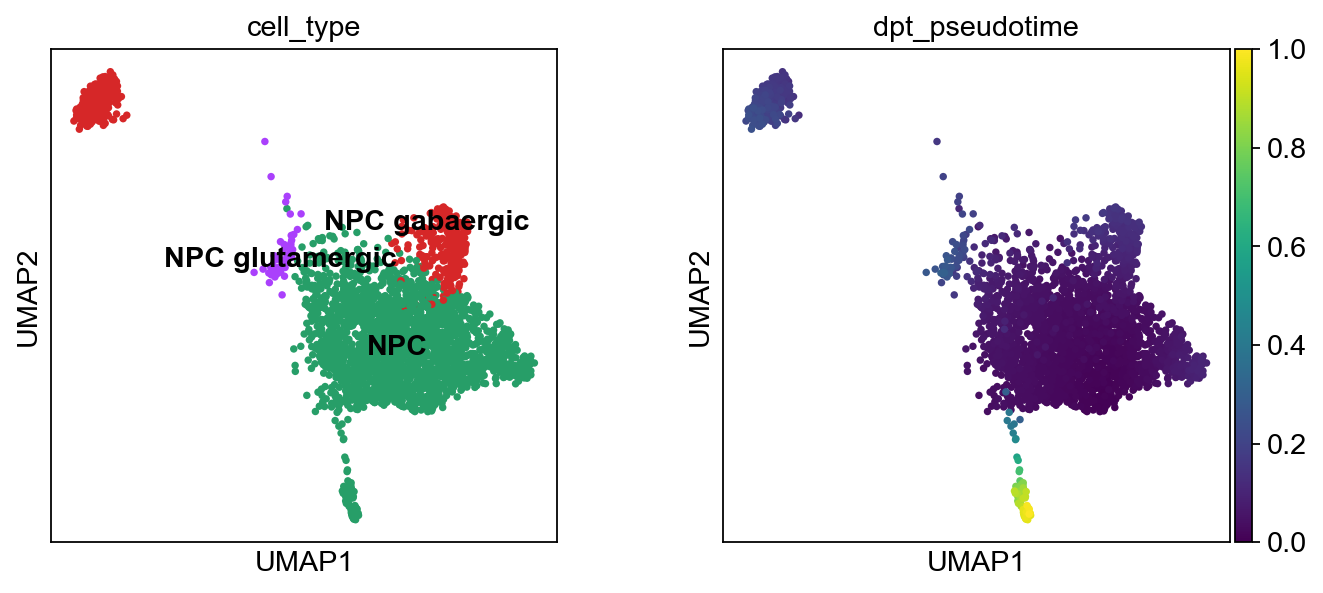

In [59]:
# Choose a root cel for diffusion
NPC.uns['iroot'] = np.flatnonzero(NPC.obs['cell_type']  == 'NPC')[4]
sc.tl.diffmap(NPC)
sc.tl.dpt(NPC)
sc.pl.umap(NPC, color=['cell_type', 'dpt_pseudotime'], legend_loc='on data')


In [60]:
NPC.obs['cell_type'].value_counts()

cell_type
NPC                2182
NPC gabaergic       413
NPC glutamergic      57
Name: count, dtype: int64

In [61]:
target_cells = 57
tmp = [NPC[NPC.obs['cell_type'] == s] for s in NPC.obs['cell_type'].cat.categories]

for dat in tmp:
    if dat.n_obs > target_cells:
         sc.pp.subsample(dat, n_obs=target_cells)

npc_sampled = tmp[0].concatenate(*tmp[1:])
npc_sampled.obs['cell_type'].value_counts()

C:\Users\jurri\AppData\Local\Temp\ipykernel_52736\2450881020.py:8: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  npc_sampled = tmp[0].concatenate(*tmp[1:])


cell_type
NPC                57
NPC gabaergic      57
NPC glutamergic    57
Name: count, dtype: int64

In [62]:
sc.tl.rank_genes_groups(npc_sampled , 'cell_type', use_raw=False, method='wilcoxon', key_added = "wilcoxon")

c:\Users\jurri\miniconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


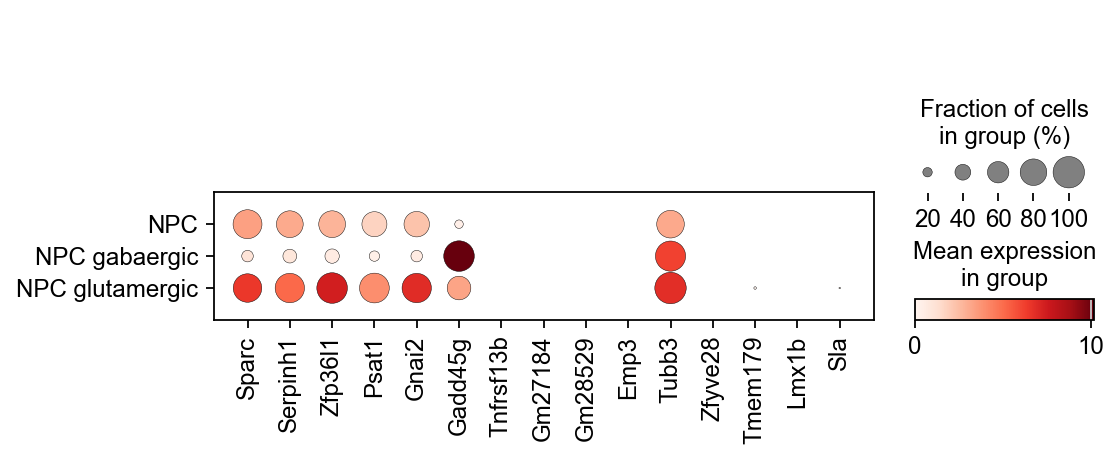

In [63]:
npc_genes = []
for cat in npc_sampled.obs["cell_type"].unique():
    npc_genes += sc.get.rank_genes_groups_df(npc_sampled, group=cat, key='wilcoxon')['names'][:5].tolist()

sc.pl.dotplot(npc_sampled,npc_genes, groupby='cell_type')